In [1]:
import yaml
import numpy as np
import zstandard as zstd
import matplotlib.pyplot as plt
import os

def load_ampl_from_zstd(input_path, n_traces, dtype=np.float16, trace_shape=(9, 217233)) -> np.ndarray:
    """
    Load a list of numpy arrays (traces) from a compressed Zstandard (.zst) file and return a single stacked ndarray.
    """
    def unshuffle_bytes(data: bytes, dtype=np.float16, shape=(9, 217233)) -> np.ndarray:
        itemsize = np.dtype(dtype).itemsize
        num_elements = np.prod(shape)
        reshaped = np.frombuffer(data, dtype=np.uint8).reshape(itemsize, num_elements).T
        unshuffled = reshaped.reshape(-1)
        return unshuffled.view(dtype).reshape(shape)

    decompressor = zstd.ZstdDecompressor()
    with open(input_path, 'rb') as f:
        compressed_content = f.read()
        decompressed = decompressor.decompress(compressed_content)

    trace_size_bytes = np.prod(trace_shape) * np.dtype(dtype).itemsize
    expected_size = n_traces * trace_size_bytes
    if len(decompressed) != expected_size:
        raise ValueError("Decompressed size does not match expected size")

    traces = []
    for i in range(n_traces):
        start = i * trace_size_bytes
        end = start + trace_size_bytes
        trace_bytes = decompressed[start:end]
        trace = unshuffle_bytes(trace_bytes, dtype=dtype, shape=trace_shape)
        traces.append(trace)

    return np.stack(traces).astype(np.float32)

def plot_traces(traces, fs=3_906_250, offset_step=70, title="QP Traces"):
    if traces.ndim == 3 and traces.shape[0] == 1:
        traces = traces[0]

    num_channels, num_samples = traces.shape
    time_ms = np.arange(num_samples) / fs * 1000  # Time in ms

    plt.figure(figsize=(18, 12))
    
    for i in range(num_channels):
        color = 'orange' if i > 44 else 'tab:blue'
        plt.plot(time_ms, traces[i] + i * offset_step, lw=0.3, color=color)

    plt.xlabel("Time [ms]", fontsize=16)
    plt.ylabel("Offset ADC counts", fontsize=16)
    plt.title(title, fontsize=18)
    plt.xlim(0, time_ms[-1])
    plt.ylim(-10, offset_step * (num_channels + 1))
    plt.yticks([])  # Hide y-axis ticks

    plt.tight_layout()
    plt.show()

In [5]:
loaded_trace = load_ampl_from_zstd("/ceph/dwong/trigger_samples/lts/ampl_energy_95.zst", 100)

In [6]:
loaded_trace.shape

(100, 9, 217233)

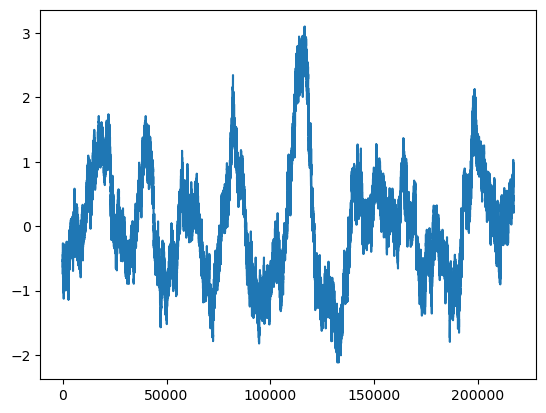

In [8]:
plt.plot(loaded_trace[10][7])